In [2]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain.document_loaders import PyMuPDFLoader, PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.documents.base import Document
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.output_parsers.string import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_experimental.utilities import PythonREPL
from pydantic import BaseModel, Field
import dotenv
import os

dotenv.load_dotenv()

True

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

embeddings = OpenAIEmbeddings()

file_path = "./files/Practice_document.pdf"

In [ ]:
# 리트리버 생성

def embedding_file(file_path):
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=300,
        chunk_overlap=50,
        separators=["\n\n"],
    )

    loader = PyPDFLoader(f"{file_path}")
    docs = loader.load_and_split(text_splitter=splitter)

    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(docs, embeddings)
    retriever = vector_store.as_retriever()

    return retriever

In [28]:
retriever = embedding_file(file_path)

In [371]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM Response"]
    document : Annotated[Document, "Retrieve Response"]

In [372]:
# # Start -> get_initial_state

# def get_initial_state(state:State):
#     if state.get("init_state"):
#         print("====== Already State ======")
#         return state
#     else:
#         print("====== State Init Complete ======")
#         return {"answer":"",
#                 "init_state":True,
#                 }

In [373]:
def create_document(state:State):
    docs = retriever.invoke(state["query"])

    docs = "\n\n".join(doc.page_content for doc in docs)

    return {"document":docs}

In [374]:
def create_prompt(state:State):
    prompt = ChatPromptTemplate.from_messages([
                ("system", 
                """
                context : {context}

                당신은 언제나 고객에게 최선을 다해 답변을 하며 말투는 굉장히 친근합니다. 직업은 전문 상담원입니다. 답변 시, 아래의 규칙을 지켜야만 합니다.
                ---
                ### 규칙 ###
                1. 주어진 context만을 이용하여 답변해야합니다. 
                2. 주어진 context에서 답변을 할 수 없다면 "해당 문의는 010-2255-3366으로 연락주시면 도와드리겠습니다. 영업 시간은 오전 10시-오후 6시입니다." 라고 대답하세요.
                3. 문자열에 A1, A2, A11, A22 등 필요 없는 문자는 제거한 뒤 출력합니다.
                4. 항상 친절한 말투로 응대합니다.
                5. 하이퍼 링크를 그대로 출력합니다. 대소문자를 명확하게 구분하세요. 아래 예시를 참고하여 서식을 맞추세요.
                **하이퍼 링크 예시**
                5-1. [스타벅스 구역삼사거리점](https://naver.me/FV7K6xTM) 입니다.
                5-2. [화목순대국](https://naver.me/FQVGK6TZ) 입니다.
                5-3. [모두의연구소 역삼캠퍼스](https://naver.me/GMvc9Hv5) 입니다.
                ---
                """),
                ("human", "{query}")
            ])
    
    chain = prompt | llm

    return {"answer": chain.invoke({"context" : state["document"],
                                    "query": state["query"]})}

In [375]:
graph_builder = StateGraph(State)

In [ ]:
graph_builder.add_node("format_docs", create_document);
graph_builder.add_node("prompt1", create_prompt);

graph_builder.add_edge(START, "format_docs");
graph_builder.add_edge("format_docs", "prompt1");
graph_builder.add_edge("prompt1", END); 

In [377]:
graph = graph_builder.compile()

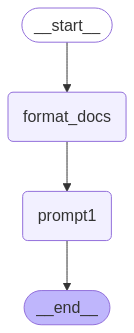

In [378]:
graph

In [379]:
invoke_result = graph.invoke({"query":"개강하는 날짜는 언제인가요?"})

In [380]:
invoke_result["answer"].content

'아이펠 데이터사이언티스트 3 기의 개강일은 2024년 9월 25일입니다.'

In [381]:
invoke_result = graph.invoke({"query":"오프라인 강의인가요?"})

In [382]:
invoke_result["answer"].content

'아이펠 교육과정은 100% 실시간 온라인 과정으로 화상 플랫폼(ZEP)에서 진행됩니다. 하지만 희망하시는 경우, 오프라인 학습 공간(모두의연구소 강남 / 역삼캠퍼스)을 무료로 제공해드리고 있습니다. 공간 사용방법은 입학 후 별도로 안내드릴 예정입니다.'